In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

 >> Context(max_t=3.0, dt=0.1, n_instances=30, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

Here - decoder: x -> sin(x)

In [8]:
def gen_xy_sin_to_f(n_samples=500, n_t=100, f=None, dt=0.01):
    # x_train = array (unique_samples, xs_over_t, sin(xs))
    # y_train = array (unique_samples, xs_over_t, sin(xs + dx))
    max_t = n_t * dt
    min_f = utils.min_f(max_t)
    max_f = utils.max_f(dt)
    print('allowed min max f', min_f, max_f)
    min_f = 9
    max_f = 9
    if f is None:
        fs = np.random.random(n_samples) * (max_f - min_f) + min_f
    else:
        fs = np.repeat(f, n_samples)
        
    phases = np.random.random(n_samples) * 2*np.pi
    timesteps = np.arange(n_t) * dt
    x_train = []
    y_train = []    
    for i, phase in enumerate(phases):
        # x: beginning of cycle
        f = fs[i]
        d_phase = n_t * dt * f
        x_train.append(sin_(n_t, f, phase))
        # y: continuation of cycle        
        y_train.append(sin_(n_t, f, phase + d_phase))
    
    x_train = np.stack(x_train)
    x_train = x_train.reshape(n_samples, n_t, 1) 
    y_train = np.stack(y_train)
    y_train = y_train.reshape(n_samples, n_t, 1)
    return x_train, y_train
    
def sin_(n, f, phase=0, dt=0.01):
    phase = 0
    ts = np.arange(n) * dt
    return (np.sin(2*np.pi * f * ts + phase * 2 * np.pi) + 1) * 0.5

def categorize_array(array, n_categories=10):
    # transform an array of values in range [0,1] to an array of one hot vectors
    # array :: (samples, timesteps, value)
    # ouput :: (samples, timesteps, value-array)
    enc = sklearn.preprocessing.OneHotEncoder(categorical_features='all', dtype=np.float,
       handle_unknown='error', n_values=n_categories, sparse=False)
    range_array = np.arange(n_categories).reshape(n_categories, 1)
    enc.fit(range_array)
    
    # iterate, for every value: transform(value) -> one hot vector
    dims = list(array.shape)
    dims[-1] = n_categories
    new = np.empty(dims)
    # encode using batches of 1 sample (thus, x timesteps) 
    it = np.nditer(array[:,0,0], flags=['multi_index'])
    while not it.finished:
        index_sample = it.multi_index
        values = array[index_sample]
        encoded = enc.transform(values * (n_categories-1))
        new[index_sample] = encoded
        it.iternext()
    return new

def value_to_vector(value, n_categories=3, default=1):
    # sklearn.preprocessing.OneHotEncoder
    # 0 <= value < 1
    vector = np.zeros(n_categories)
    index = round(value * (n_categories-1)) # value / 1 / n;    n-1 to fix indexing
    vector[index] = default
    return vector
    
def vector_to_number(vector):
    n = vector.shape[0]
    # estimate the breakpoints (a la quantiles, percentiles)
    breakpoints = [ x * 1.0/n for x in range(n)]
    index = vector.argmax()
    return breakpoints[index]

In [14]:
n = 100
f = None
# f = 3
dt = 0.01
x_train, y_train = gen_xy_sin_to_f(n, f=f, dt=dt) # encoder_input_data
x_train = categorize_array(x_train)
y_train = x_train[:,:-1,:]
z_train = x_train[:,1:,:]

encoder_input_data = y_train # english sentences
decoder_input_data = y_train # french sentences (copy)
decoder_target_data = z_train # french sentences, next timestep

x_test, y_test = gen_xy_sin_to_f(10, f=f, dt=dt)
x_test = categorize_array(x_test)
print(x_train.shape, y_train.shape, z_train.shape)

allowed min max f 1.0 50.0
allowed min max f 1.0 50.0
(100, 100, 10) (100, 99, 10) (100, 99, 10)


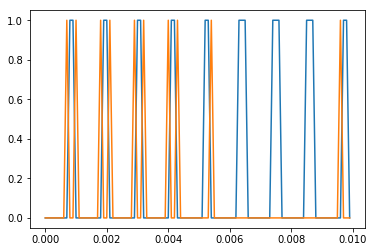

In [43]:
n4 = x_train.shape[1]
plt.plot(np.arange(n4) / n4 * dt, x_train[0,:,:2])

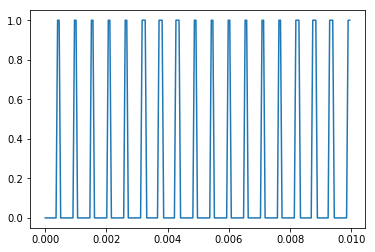

In [44]:
full = np.concatenate([x_train[0,:,0],y_train[0,:,0]])
n5 = full.shape[0]
plt.plot(np.arange(n5) / n5 * dt, full)

In [10]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(99, 1)

In [11]:
output_shape

(99, 1)

In [24]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
latent_dim = 64

In [79]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, None, 10)     0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, None, 10)     0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 64), (None,  19200       input_17[0][0]                   
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, None, 64), ( 19200       input_18[0][0]                   
                                                                 lstm_12[0][1]                    
          

In [80]:
# encoder.summary()
# decoder.summary()

In [81]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'categorical_crossentropy'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae'])#, metrics=metrics)

In [82]:
batch_size = 1
# n epochs = n iterations over all the training data
epochs = 6

In [83]:
callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
vs = 1/6
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
model.fit([x_train,y_train], z_train, epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks)

Train on 83 samples, validate on 17 samples
Epoch 1/6
83/83 [==============================] - 10s 115ms/step - loss: 1.9330 - mean_squared_error: 0.2158 - mean_absolute_error: 0.3785 - val_loss: 1.7785 - val_mean_squared_error: 0.1467 - val_mean_absolute_error: 0.2873
Epoch 2/6
83/83 [==============================] - 9s 114ms/step - loss: 1.4852 - mean_squared_error: 0.0885 - mean_absolute_error: 0.1912 - val_loss: 1.1599 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.1278
Epoch 3/6
83/83 [==============================] - 9s 113ms/step - loss: 0.9443 - mean_squared_error: 0.0633 - mean_absolute_error: 0.1099 - val_loss: 0.7494 - val_mean_squared_error: 0.0669 - val_mean_absolute_error: 0.0991
Epoch 4/6
83/83 [==============================] - 9s 109ms/step - loss: 0.6360 - mean_squared_error: 0.0686 - mean_absolute_error: 0.0954 - val_loss: 0.5168 - val_mean_squared_error: 0.0745 - val_mean_absolute_error: 0.0936
Epoch 5/6
83/83 [==============================] - 9s 1

# Inferencing

In [84]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [85]:
encoder_model.summary()
decoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, None, 10)          0         
_________________________________________________________________
lstm_12 (LSTM)               [(None, 64), (None, 64),  19200     
Total params: 19,200
Trainable params: 19,200
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, None, 10)     0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 64)           0                                            
_______________________________________

In [94]:
def decode_sequence(input_seq, encoder_model, decoder_model):
    max_decoder_seq_length = 100
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = sampled_token_index # reverse_target_char_index[sampled_token_index]
        decoded_sentence.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [95]:
result = decode_sequence(y_train[:], encoder_model, decoder_model)
result[0:3]

[6, 8, 8]

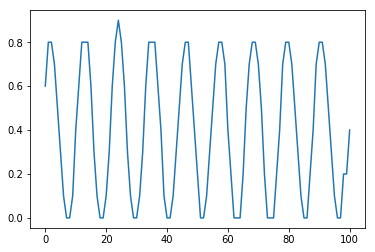

In [96]:
plt.plot(np.array(result) / 10.)

## Alt
Without teacher forcing

In [104]:
from keras.layers import Lambda
from keras import backend as K

# The first part is unchanged
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder(encoder_inputs)
states = [state_h, state_c]

# Set up the decoder, which will only process one timestep at a time.
decoder_inputs = Input(shape=(1, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# output will be a probability distribution over the vectors
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

all_outputs = []
inputs = decoder_inputs
max_decoder_seq_length = 100
for _ in range(max_decoder_seq_length):
    # Run the decoder on one timestep
    outputs, state_h, state_c = decoder_lstm(inputs,
                                             initial_state=states)
    outputs = decoder_dense(outputs)
    # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
    # Reinject the outputs as inputs for the next loop iteration
    # as well as update the states
    inputs = outputs
    states = [state_h, state_c]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define and compile model as previously
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

KeyboardInterrupt: 

In [101]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Prepare decoder input data that just contains the start character
# Note that we could have made it a constant hard-coded in the model
decoder_input_data = np.zeros((x_train.shape[0], 1, num_decoder_tokens))

# Train model as previously
model.fit([x_train,y_train], z_train, epochs=10, batch_size=batch_size,
          validation_split=0.2, callbacks=callbacks)

ValueError: Error when checking input: expected input_26 to have shape (1, 10) but got array with shape (99, 10)

In [18]:
x_test.shape

(10, 100, 1)

In [19]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [20]:
results = model.predict([x_test,x_test])
results.shape

(10, 100, 1)

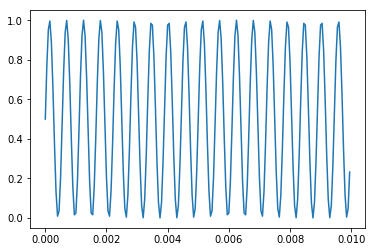

In [21]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

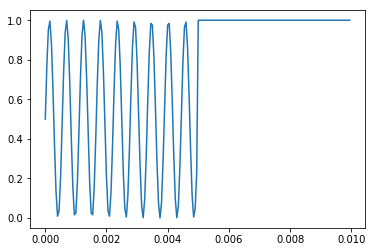

In [22]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

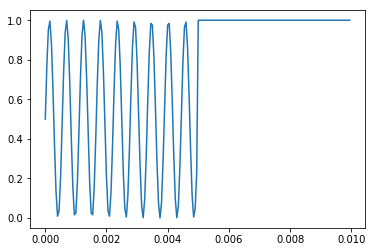

In [23]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

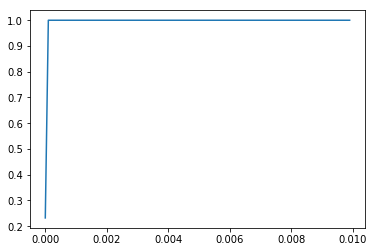

In [24]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)